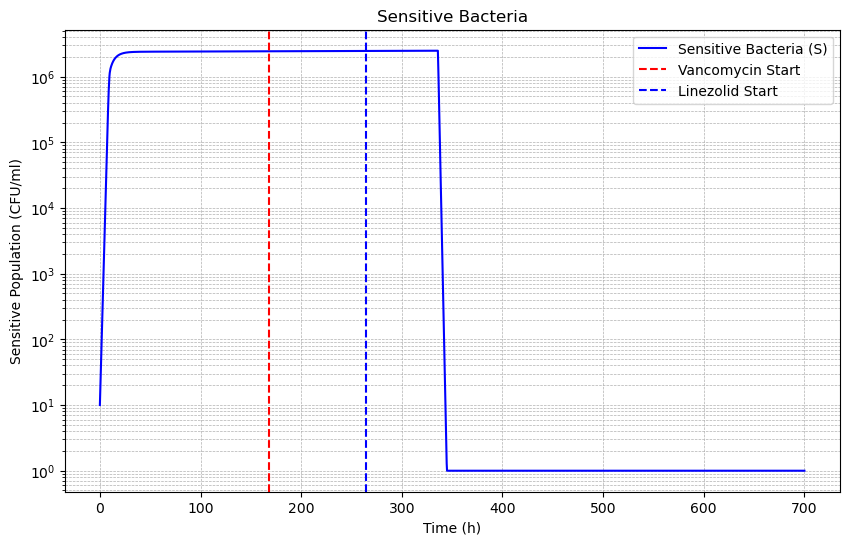

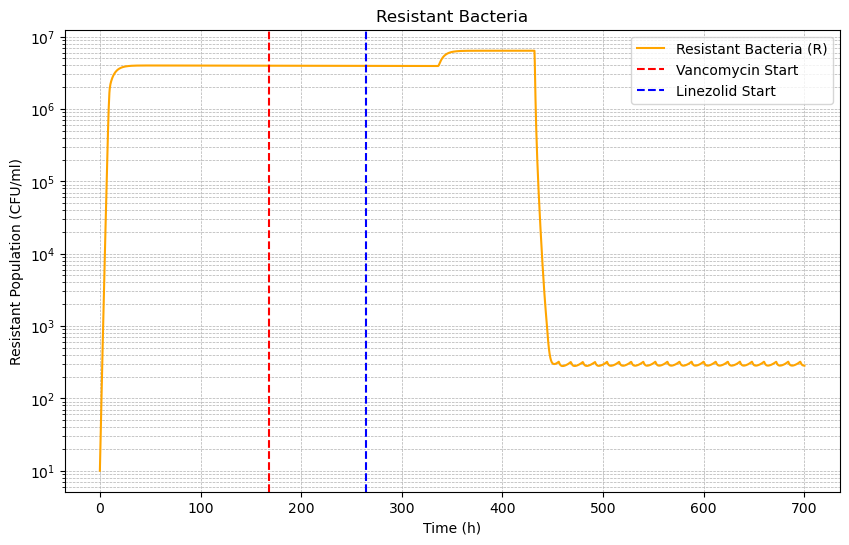

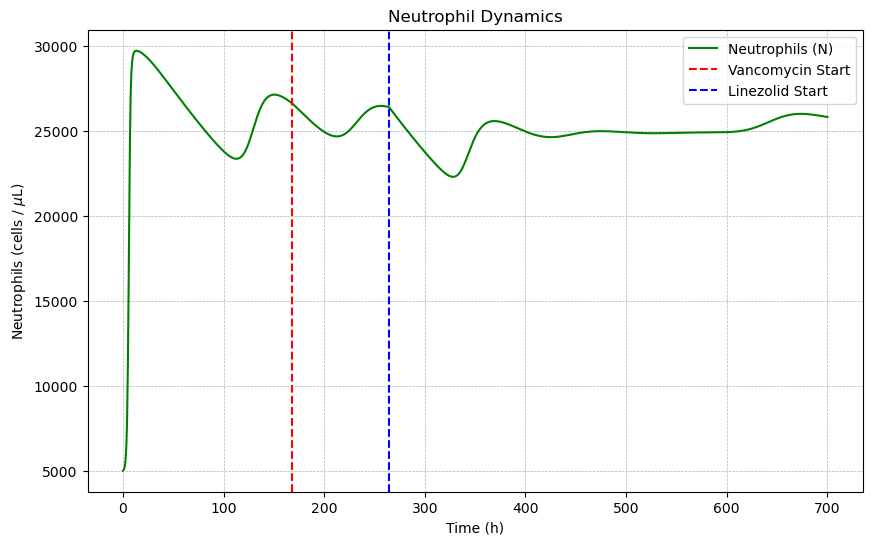

In [135]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Pharmacokinetic Model (returns functions directly) ---
class PharmacokineticModel:
    def __init__(self):
        # Vancomycin
        self.van_dose = 1200
        self.van_interval = 6
        self.van_duration = 96
        self.van_ke = 0.173
        self.van_volume = 50
        # Linezolid
        self.lzd_dose = 800
        self.lzd_interval = 12
        self.lzd_duration = 300
        self.lzd_ke = 0.116
        self.lzd_volume = 45

    def concentration_function(self, drug_type, total_time_h, start_h=0):
        """Returns a function conc(t) for the drug concentration over time."""
        if drug_type == 'vancomycin':
            dose, interval, duration, ke, volume = self.van_dose, self.van_interval, self.van_duration, self.van_ke, self.van_volume
        else:
            dose, interval, duration, ke, volume = self.lzd_dose, self.lzd_interval, self.lzd_duration, self.lzd_ke, self.lzd_volume

        t_points = np.linspace(0, total_time_h, int(total_time_h*10)+1)
        conc = np.zeros_like(t_points)
        for dt in np.arange(start_h, start_h + duration, interval):
            mask = t_points >= dt
            conc[mask] += (dose/volume) * np.exp(-ke*(t_points[mask]-dt))
        conc[t_points < start_h] = 0

        def conc_func(t):
            return np.interp(t, t_points, conc)
        return conc_func

# --- Immune Response Model ---
class ImmuneResponse:
    def __init__(self, rho_N=1e-4, N_MAX=30000, delta_N=0.003, kill_N=5e-5, N0=5000):
        self.rho_N = rho_N
        self.N_MAX = N_MAX
        self.delta_N = delta_N
        self.kill_N = kill_N
        self.N0 = N0
        

    def compute(self, N, A_total, t=None):
        """Compute neutrophil growth and effective killing (full killing immediately).
        Immune killing is saturable with bacteria: kill_N * N * B_total / (K_imm + B_total)"""
        dN = self.rho_N * N * A_total * (1 - N/self.N_MAX) - self.delta_N * N
        immune_effect = self.kill_N * N
        return dN, immune_effect

# --- ODE system ---
def immune_and_pd_model(y, t, params, van_func, lzd_func, immune_model):
    S, R, R_res, N = y
    V = max(0, van_func(t))
    L = max(0, lzd_func(t))
    S, R, R_res, N = max(S,0), max(R,0), max(R_res,0), max(N,0)
    A_total = S + R + R_res

    h_V = h_L = 1
    linezolid_inhibition = (params['Emax_l'] * L**h_L) / (params['EC50_L']**h_L + L**h_L)
    vancomycin_kill = (params['Emax_v'] * V**h_V) / (params['EC50_V']**h_V + V**h_V)
    logistic = (1 - A_total / params['B_max'])

    # --- Immune Response ---
    dN, immune_effect = immune_model.compute(N, A_total, t)
    immune_S = immune_effect * S
    immune_R = immune_effect * R
    immune_Ares = immune_effect * R_res

    # --- Sensitive & Resistant Bacterial population dynamics ---
    dS = params['rho_S']*S*logistic - params['delta']*S - immune_S - vancomycin_kill*S - linezolid_inhibition*S
    dR = params['rho_R']*R*logistic - params['delta']*R - immune_R - linezolid_inhibition*R + params['f_r_b']*R_res - params['f_b_r']*R
    dA_res = (params['rho_res']*R_res*(1-R_res/params['k_res']) - params['delta_res']*R_res
              - params['f_r_b']*R_res + params['f_b_r']*R - immune_Ares)

    return [dS, dR, dA_res, dN]

# --- Simulation ---
total_h = 700
pk = PharmacokineticModel()
immune_model = ImmuneResponse(N0=5000)  

vanco_start = 168
lzd_start = vanco_start + pk.van_duration

van_func = pk.concentration_function('vancomycin', total_h, vanco_start)
lzd_func = pk.concentration_function('linezolid', total_h, lzd_start)

params = {
    'rho_S':1.47,#rate of growth for sensitive bacteria
    'rho_R':1.47,#rate of growth for resistant bacteria
    'B_max':4e12,# bacterial carry capacity (CFU/ml)
    'delta':0.179, # Sensitive and Resistant Natural death rate (h^-1)
    'Emax_v':1.74,
    'Emax_l':1.97,
    'EC50_V':0.245,# Vancomycin concentration for 50% max effect (mg/L)
    'EC50_L':0.56,# Linezolid concentration for 50% max effect (mg/L)
    'rho_res':1.47, # Growth rate of reservoir bacteria (h^-1)
    'k_res':1e4,#resevoir carry capacity
    'delta_res':0.179, # Natural death rate of reservoir bacteria (h^-1)
    'f_r_b':0.02,# transfer rate from reservoir compartment to blood compartment
    'f_b_r':0.0002# transfer rate from blood compartment to resevoir compartment
}

y0 = [1e1, 1e1, 1e2, immune_model.N0]
t_eval = np.linspace(0, total_h, 2000)
solution = odeint(immune_and_pd_model, y0, t_eval, args=(params, van_func, lzd_func, immune_model))

# --- Prepare bacterial data (clip at 1 to avoid log(0)) ---
#S_plot = np.clip(solution[:,0], 1, None)
#R_plot = np.clip(solution[:,1], 1, None)
#Ares_plot = np.clip(solution[:,2], 1, None)

# --- Plot Sensitive Bacteria ---
plt.figure(figsize=(10,6))
plt.plot(t_eval, S_plot, label='Sensitive Bacteria (S)', color='blue')
plt.yscale('log')
plt.xlabel('Time (h)')
plt.ylabel('Sensitive Population (CFU/ml)')
plt.title('Sensitive Bacteria')
plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
#plt.show()

# --- Plot Resistant Bacteria ---
plt.figure(figsize=(10,6))
plt.plot(t_eval, R_plot, label='Resistant Bacteria (R)', color='orange')
plt.yscale('log')
plt.xlabel('Time (h)')
plt.ylabel('Resistant Population (CFU/ml)')
plt.title('Resistant Bacteria')
plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
#plt.show()

# --- Plot Reservoir ---
#plt.figure(figsize=(10,6))
#plt.plot(t_eval, Ares_plot, label='Reservoir (R_res)', color='purple')
#plt.yscale('log')
#plt.xlabel('Time (h)')
#plt.ylabel('Reservoir Population (CFU/ml)')
#plt.title('Reservoir Bacteria')
#plt.yticks([1, 10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10])
#plt.ylim(1, max(Ares_plot)*1.2)
#plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
#plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
#plt.grid(True, which="both", ls="--", lw=0.5)
#plt.legend()
#plt.show()


# --- Plot Neutrophils Separately ---
plt.figure(figsize=(10,6))
plt.plot(t_eval, solution[:,3], color='green', label='Neutrophils (N)')
plt.xlabel('Time (h)') 
plt.ylabel(r'Neutrophils (cells / $\mu$L)')
plt.title('Neutrophil Dynamics')
plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
plt.grid(True, ls="--", lw=0.5)
plt.legend()
plt.show()


In [137]:
# Print first 200 neutrophil values
N_values = solution[:, 3]
for idx, val in enumerate(N_values[:80]):
    print(f"{idx}: {val:.6f}")

t_eval[44]

0: 5000.000000
1: 5015.836613
2: 5040.833803
3: 5078.923870
4: 5135.675566
5: 5218.925164
6: 5339.606445
7: 5512.805756
8: 5759.041988
9: 6105.718221
10: 6588.589629
11: 7252.875840
12: 8153.142307
13: 9349.973796
14: 10899.638207
15: 12831.759788
16: 15114.477069
17: 17622.971313
18: 20146.618964
19: 22455.549588
20: 24388.286480
21: 25893.138046
22: 27006.265966
23: 27804.307897
24: 28367.722615
25: 28763.788990
26: 29042.958553
27: 29241.015095
28: 29382.661948
29: 29484.774503
30: 29558.871755
31: 29612.855865
32: 29652.193381
33: 29680.704933
34: 29701.090914
35: 29715.282206
36: 29724.675607
37: 29730.293218
38: 29732.891281
39: 29733.035404
40: 29731.153044
41: 29727.570498
42: 29722.539286
43: 29716.255149
44: 29708.871836
45: 29700.511254
46: 29691.270970
47: 29681.229818
48: 29670.452132
49: 29658.990946
50: 29646.890453
51: 29634.187887
52: 29620.914987
53: 29607.099138
54: 29592.764256
55: 29577.931496
56: 29562.619797
57: 29546.846323
58: 29530.626811
59: 29513.975843
60: 

15.407703851925964